In [1]:
import sys
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install geopy

     |████████████████████████████████| 102kB 2.4MB/s 


In [0]:
import pandas as pd
import numpy as np
import geocoder
import requests
from bs4 import BeautifulSoup

In [4]:
# get text version of html of wiki page to be scraped
scrape_url = 'https://en.wikipedia.org/wiki/List_of_Melbourne_suburbs'
html_url = requests.get(scrape_url).text

# create object with nested tags via BeautifulSoup 
soup = BeautifulSoup(html_url)

# filter for table
table = soup.find('table',{'class':'wikitable sortable'})

# filter for fields
table_parts = table.find_all('td')

# initiate empty dataframe with column names, to loop over the html table, and append 1 row at a time
col_names = ['Suburb','Postcode', 'Latitude', 'Longitude']
geo_melb = pd.DataFrame(columns=col_names)

# loop over separated html and append to df row by row

for i in range(0,len(table_parts),9):
    suburb, pc = table_parts[i].text.strip(), table_parts[i+1].text.strip()
    geo_melb = geo_melb.append({'Suburb':suburb,
                   'Postcode':pc},
                               ignore_index=True)
geo_melb.tail()

,Suburb,Postcode,Latitude,Longitude
544,Woori Yallock,3139,NaN,NaN
545,Yarra Glen,3775,NaN,NaN
546,Yarra Junction,3797,NaN,NaN
547,Yellingbo,3139,NaN,NaN
548,Yering,3770,NaN,NaN


In [0]:
# will add the coordinates by postcode from geopy package
from geopy import geocoders

In [0]:
# loop over dataframe and get latitude and longitude for each post code
geolocator = geocoders.Nominatim(user_agent='airbnb_advice')

for i in range(geo_melb.shape[0]):
  
  temp_postcode = geo_melb.iloc[i,1]
  location = geolocator.geocode('{}, AUSTRALIA'.format(temp_postcode))
  geo_melb.iloc[i,2] = location.latitude
  geo_melb.iloc[i,3] = location.longitude

In [8]:
geo_melb.head(2)

,Suburb,Postcode,Latitude,Longitude
0,Bellfield,3081,-37.7357,145.05
1,Briar Hill,3088,-37.7046,145.11


In [11]:
geo_melb.info()

# since there are no null values, i will keep going and get the venue categories per suburb via FourSquare API

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 4 columns):
Suburb       549 non-null object
Postcode     549 non-null object
Latitude     549 non-null object
Longitude    549 non-null object
dtypes: object(4)
memory usage: 17.2+ KB


In [0]:
#@title
# will connect to FourSquare, get the nearby venues for each

CLIENT_ID = '0TXXJO31MCIJRRUU0UFGGCNQ31L2HBMJMVJOODR2XQNZHASE' # your Foursquare ID
CLIENT_SECRET = 'TSGEUBP2N34U5NKGPJDS5HBWU5ZEW0BSOZNAFQ2ZVURGIDUW' # your Foursquare Secret
VERSION = '20190726' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
# create new dataframe with nearby venues
limit = 100
melb_venues = getNearbyVenues(names=geo_melb['Suburb'],
                             latitudes=geo_melb['Latitude'],
                             longitudes=geo_melb['Longitude'])

Bellfield
Briar Hill
Bundoora
Eaglemont
Eltham
Eltham North
Greensborough
Heidelberg
Heidelberg Heights
Heidelberg West
Ivanhoe
Ivanhoe East
Lower Plenty
Macleod
Montmorency
Rosanna
St Helena
Viewbank
Watsonia
Watsonia North
Yallambie
Beaumaris
Black Rock
Brighton
Brighton East
Cheltenham
Gardenvale
Hampton
Hampton East
Highett
Moorabbin
Sandringham
Ashburton
Balwyn
Balwyn North
Camberwell
Canterbury
Deepdene
Glen Iris
Hawthorn
Hawthorn East
Kew
Kew East
Mont Albert
Mont Albert North
Surrey Hills
Albanvale
Albion
Ardeer
Brooklyn
Cairnlea
Calder Park
Deer Park
Delahey
Derrimut
Hillside
Kealba
Keilor
Keilor Downs
Keilor East
Keilor Lodge
Keilor North
Keilor Park
Kings Park
St Albans
Sunshine
Sunshine North
Sunshine West
Sydenham
Taylors Lakes
Tullamarine
Beaconsfield
Emerald
Officer
Pakenham
Avonsleigh
Bayles
Beaconsfield Upper
Bunyip
Bunyip North
Caldermeade
Cardinia
Catani
Clematis
Cockatoo
Cora Lynn
Dalmore
Dewhurst
Garfield
Garfield North
Gembrook
Guys Hill
Heath Hill
Iona
Koo Wee Ru

In [20]:
melb_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bellfield,-37.735707,145.049696,Latitude,-37.733320,145.049530,Recreation Center
1,Bellfield,-37.735707,145.049696,Waterdale Road Foodworks,-37.736362,145.048651,Convenience Store
2,Bellfield,-37.735707,145.049696,Waterdale Fish & Chips,-37.736390,145.048500,Fish & Chips Shop
3,Bellfield,-37.735707,145.049696,Fowl Play Charcoal Chicken,-37.737430,145.046907,Fried Chicken Joint
4,Briar Hill,-37.704640,145.109652,WaterMARC,-37.704519,145.104846,Swim School


In [34]:
# Get dataframe machine learning ready by 
# labeling and unstacking Venue Category column 
# grouping by Neighborhood column and creating a frequency for each venue type

venue_labels = pd.get_dummies(melb_venues['Venue Category'], drop_first = False)

# join dummy values to the dataframe
melb_dummied = pd.merge(left = melb_venues, right = venue_labels, left_index = True, right_index = True)
# drop unnecessary columns to save memory -also there's a weird Neighborhood column in JSON- 
melb_dummied.drop(labels = ['Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category','Neighborhood_y'],axis = 1, inplace = True)
melb_dummied.rename({'Neighborhood_x':'Neighborhood'},axis = 1, inplace=True)

# Group by Neighborhood and get mean to create a frequency of venue type per each Neighborhood
# Coordinates will remain the same since they will be multipled and divided by the same number
melb_grouped = melb_dummied.groupby('Neighborhood').mean().reset_index()
melb_grouped.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,...,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trade School,Trail,Train,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant
0,Abbotsford,-37.803555,144.995194,0.037037,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037037,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aberfeldie,-37.749436,144.919553,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1250,...,0.0,0.0,0.0,0.0,0.00,0.125,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aintree,-34.873065,-56.267905,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Airport West,-37.723395,144.857632,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Albanvale,-37.740779,144.798206,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Albert Park,-37.845448,144.958343,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Albion,-37.784963,144.827122,0.000000,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.187500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Alphing

**Melbourne venues are ready
Now will connect to Kaggle API and get mean house price of each suburb
This is Google Colab and I've already set the API previously. 
If interested, 
you need your Kaggle token (*.json) set at root  ***

In [36]:
!kaggle datasets download -d anthonypino/melbourne-housing-market

  0% 0.00/2.26M [00:00<?, ?B/s]
100% 2.26M/2.26M [00:00<00:00, 74.5MB/s]


In [37]:
!unzip melbourne-housing-market.zip -d /content/sample_data

Archive:  melbourne-housing-market.zip
  inflating: /content/sample_data/Melbourne_housing_FULL.csv  
  inflating: /content/sample_data/MELBOURNE_HOUSE_PRICES_LESS.csv  


In [48]:
pwd

'/'

In [63]:
# create dataframe
path = 'content/sample_data/MELBOURNE_HOUSE_PRICES_LESS.csv'

house_prices = pd.read_csv(path)
house_prices.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council


In [65]:
# dataset needs exploring to see if anything missing, skewed, biased etc.
# will just use Suburb Postcode and Price though

house_prices = house_prices[['Suburb','Postcode','Price','Rooms']]
house_prices.isnull().sum()

Suburb          0
Postcode        0
Price       14590
Rooms           0
dtype: int64

In [66]:
# checking what % of dataframe is missing values
(house_prices.isnull().sum().sum()) / (house_prices.shape[0])

0.23150278469765007

In [67]:
# Will fill missing values by the mean price of a house with that many rooms of corresponding suburb

# create a temp dataframe with mean prices of a house in each suburb
df_nona = house_prices.dropna()
avg_prices = df_nona.groupby('Postcode')[['Price']].mean()
avg_prices.head()

,Price
Postcode,
3000,7.731029e+05
3002,1.409505e+06
3003,1.041723e+06
3006,6.520588e+05
3008,6.954444e+05


In [0]:
house_prices['Price'] = house_prices.groupby(['Postcode','Rooms'])['Price'].apply(lambda x: x.fillna(x.mean()))

In [71]:
house_prices.isnull().sum()

Suburb        0
Postcode      0
Price       107
Rooms         0
dtype: int64

In [73]:
# Unique circumstances of Postcode & Rooms are still missing.
# Will just drop those
house_prices.dropna(inplace=True)
house_prices.isnull().sum()

Suburb      0
Postcode    0
Price       0
Rooms       0
dtype: int64

In [74]:
house_prices.head()

,Suburb,Postcode,Price,Rooms
0,Abbotsford,3067,1490000.0,3
1,Abbotsford,3067,1220000.0,3
2,Abbotsford,3067,1420000.0,3
3,Aberfeldie,3040,1515000.0,3
4,Airport West,3042,670000.0,2


In [75]:
# since this dataset is all clear now, 
# will group this by Suburb and get mean price per suburb
# then merge to the venues dataframe

houses_grouped = house_prices.groupby('Suburb')[['Postcode', 'Price']].mean().reset_index()
houses_grouped.head()

,Suburb,Postcode,Price
0,Abbotsford,3067,1.065107e+06
1,Aberfeldie,3040,1.351314e+06
2,Airport West,3042,7.760442e+05
3,Albanvale,3021,5.468430e+05
4,Albert Park,3206,2.054282e+06


In [84]:
final_df = pd.merge(left = melb_grouped, right = houses_grouped, left_on = 'Neighborhood', right_on = 'Suburb', how = 'left')
final_df.shape

(459, 276)

In [80]:
final_df['Price'].isnull().sum()

133

In [96]:
# Unfortunately the dataset doesnt include sales for 133 of the suburbs.
# will just drop those
# and will create bins for the prices 
final_df.dropna(inplace = True)

bins = np.linspace(final_df['Price'].min(), final_df['Price'].max(), 6)
labels = 'Low Mid-Low Mid Mid-High High'.split()

price_labels = pd.cut(final_df['Price'], bins = bins, labels = labels, include_lowest = True)
final_df.insert(0,'Price Bracket',price_labels)
final_df.head()

,Price Bracket,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,...,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trade School,Trail,Train,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Suburb,Postcode,Price
0,Mid-Low,Abbotsford,-37.803555,144.995194,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037037,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Abbotsford,3067.0,1.065107e+06
1,Mid,Aberfeldie,-37.749436,144.919553,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Aberfeldie,3040.0,1.351314e+06
3,Low,Airport West,-37.723395,144.857632,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Airport West,3042.0,7.760442e+05
4,Low,Albanvale,-37.740779,144.798206,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Albanvale,3021.0,5.468430e+05
5,High,Albert Park,-37.845448,144.958343,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Albert Park,3206.0,2.054282e+06


In [97]:
final_df.shape

(326, 277)

In [98]:
final_df['Price Bracket'].value_counts()

Low         134
Mid-Low     127
Mid          41
Mid-High     16
High          8
Name: Price Bracket, dtype: int64

In [99]:
# merged columns are with this dataframe, will drop those as well.
final_df.drop(labels = ['Suburb','Postcode'], inplace=True, axis = 1)
final_df.head()

,Price Bracket,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,...,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trade School,Trail,Train,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Price
0,Mid-Low,Abbotsford,-37.803555,144.995194,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037037,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.065107e+06
1,Mid,Aberfeldie,-37.749436,144.919553,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.351314e+06
3,Low,Airport West,-37.723395,144.857632,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.760442e+05
4,Low,Albanvale,-37.740779,144.798206,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.468430e+05
5,High,Albert Park,-37.845448,144.958343,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.054282e+06


In [0]:
# want to how the data is distributed before fitting to machine learning

import matplotlib.pyplot as plt
import seaborn as sns

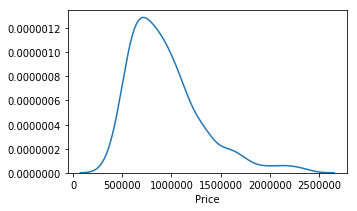

In [112]:
plt.figure(figsize = (5,3))

sns.distplot(final_df['Price'],hist=False)
plt.show()

In [132]:
# will see if any easy-to-see correlation exist between price and number of venues
venue_count = melb_venues.groupby('Neighborhood')[['Venue']].count()
venue_count.rename({'Venue':'Count'},axis=1,inplace=True)

temp_df = pd.merge(left = venue_count, right = final_df[['Neighborhood', 'Price']], on='Neighborhood')
temp_df.head()

,Neighborhood,Count,Price
0,Abbotsford,27,1.065107e+06
1,Aberfeldie,8,1.351314e+06
2,Airport West,2,7.760442e+05
3,Albanvale,9,5.468430e+05
4,Albert Park,9,2.054282e+06


In [133]:
temp_df.corr()

,Count,Price
Count,1.000000,0.245037
Price,0.245037,1.000000


**Very slow number to say there's any correleation ***

In [0]:
# will create independent value for unsupervised machine learning (clustering) 
# and will create labels, insert to dataframe and visualise on a map

to_drop = ['Price Bracket','Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Price']
x = final_df.drop(labels = to_drop, axis = 1).values

In [0]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [0]:
# will try Elbow Method to find an easy number of clusters

K = range(1,50)
n_distortions = []

for k in K:

  kmeans = KMeans(n_clusters = k).fit(x)
  n_distortions.append(sum(np.min(cdist(x, kmeans.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

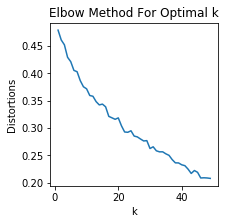

In [150]:
plt.figure(figsize=(3,3))
plt.plot(K, n_distortions)
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.show()

In [153]:
# since elbow method returned ambigious, will use 5 clusters not to overfit,
# also same number of categories of price brackets

kmeans_opt = KMeans(n_clusters = 5, random_state =42)
kmeans_opt = kmeans_opt.fit(x)

final_df.insert(0,'Cluster Labels',kmeans_opt.labels_)
final.head()

,Cluster Labels,Price Bracket,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Boxing Gym,...,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trade School,Trail,Train,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Price
0,0,Mid-Low,Abbotsford,-37.803555,144.995194,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.037037,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.065107e+06
1,0,Mid,Aberfeldie,-37.749436,144.919553,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.351314e+06
3,0,Low,Airport West,-37.723395,144.857632,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.760442e+05
4,0,Low,Albanvale,-37.740779,144.798206,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.468430e+05
5,4,High,Albert Park,-37.845448,144.958343,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.054282e+06


In [0]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors


In [163]:
# Will visualise clusters on map

# create map on melbourne
latitude = -37.803555 
longitude = 144.995194
map_clustered = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
k = 5
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_df['Neighborhood Latitude'], final_df['Neighborhood Longitude'], final_df['Neighborhood'], final_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clustered)
       
map_clustered

In [166]:
# Cafe is in Brunswick, so will see the cluster and price bracket for housing
final_df[final_df['Neighborhood'] == 'Brunswick']

,Cluster Labels,Price Bracket,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Bowling Green,Boxing Gym,...,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trade School,Trail,Train,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Price
63,4,Mid-Low,Brunswick,-37.767725,144.959508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.125,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,988714.393384


In [169]:
# will slice Similar suburbs to Brunswick
advice_df = final_df[(final_df['Cluster Labels'] == 4) & (final_df['Price Bracket'] == 'Mid-Low')]
advice_df.shape

(40, 276)

In [189]:
venue_type_count = melb_venues.groupby(['Neighborhood','Venue Category'])[['Venue']].count()
venue_type_count.reset_index(inplace=True)
cafe_count = venue_type_count[venue_type_count['Venue Category']=='Café']
cafe_count.drop(labels = 'Venue Category',axis=1, inplace =True)
cafe_count.rename({'Venue':'Cafe Count'},axis =1, inplace =True)
cafe_count.reset_index(drop=True,inplace=True)
cafe_count.head(1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Neighborhood,Cafe Count
0,Abbotsford,3


In [0]:
advice_counted = pd.merge(left = advice_df[['Neighborhood']], right = cafe_count, on='Neighborhood')

In [193]:
advice_counted.sort_values(by = 'Cafe Count').head(10)

,Neighborhood,Cafe Count
36,Wantirna South,1
2,Bentleigh East,1
35,Wantirna,1
16,Keilor East,1
23,North Warrandyte,1
8,Burwood East,1
17,Knoxfield,1
19,Montmorency,2
15,Heathmont,2
24,Notting Hill,2
